In [3]:
%pylab inline
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import warnings
from itertools import product
import matplotlib.patches as mpatches

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Этот блокнот посвящён демонстрации процесса прогнозирования временных рядов.  
Я взял датасет __Retail and Food Services Sales (RSAFSNA)__ на (https://www.kaggle.com/ "Kaggle.com")  
В нём представленны данные о продажах с 01.01.1992 по 01.09.2017 помесячно в миллионах долларов.

In [3]:
data=pd.read_csv('RSAFSNA.csv',index_col=['DATE'], parse_dates=['DATE'], dayfirst=False)

In [4]:
data.head()

,RSAFSNA
DATE,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


<Figure size 1080x720 with 0 Axes>

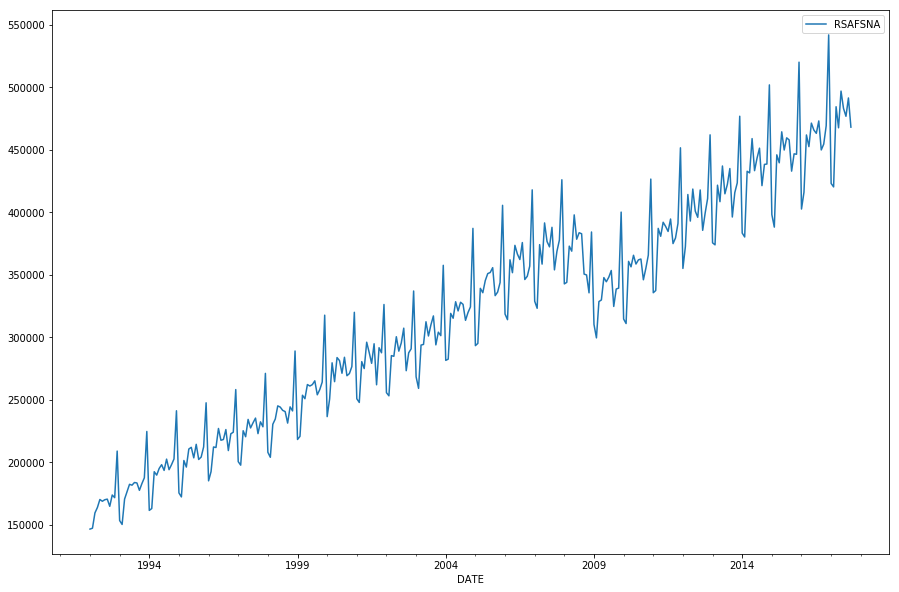

In [5]:
plt.figure(figsize(15,10))
data.plot()
plt.show()

Критерий Дики-Фуллера: p=0.932566


<Figure size 1080x720 with 0 Axes>

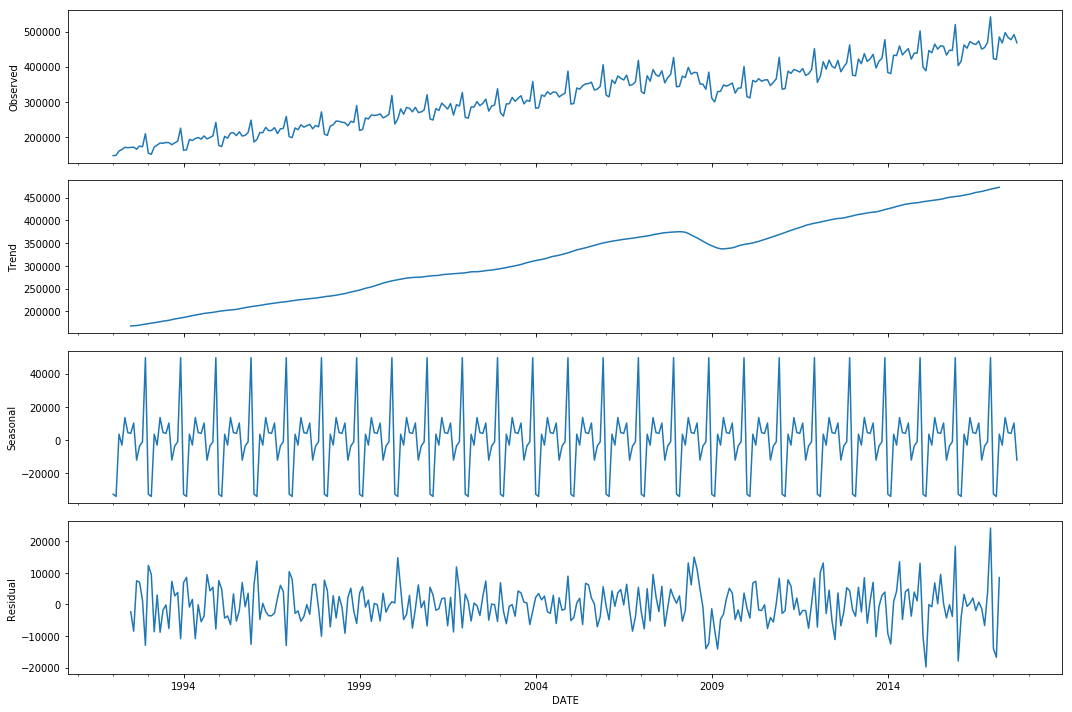

In [37]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.RSAFSNA)[1])

На графике отлично видны возрастающий тренд и ярко выраженная сезонность.  
Тренд имеет перегиб в точке кризиса августа 2008 года.
Критерий Дики-Фуллера больше 0.05, что говорит о нестационарности ряда.  
  
Чтобы стабилизировать дисперию необходимо применить преобразование Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.723943
Критерий Дики-Фуллера: p=0.878017


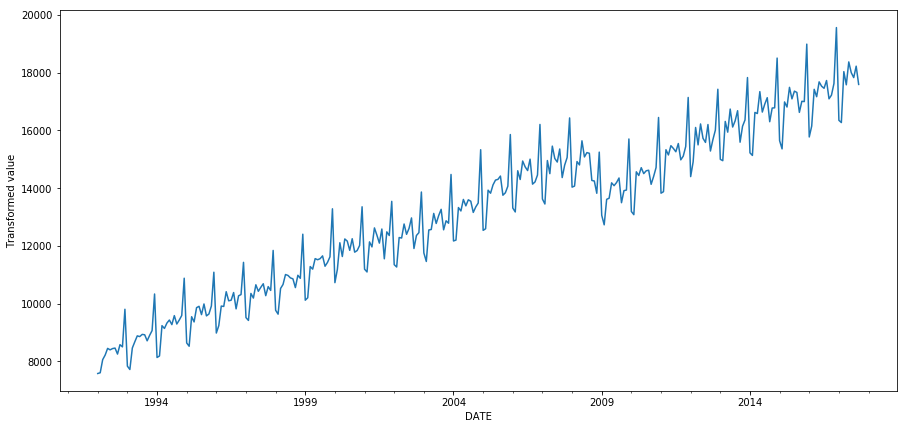

In [6]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
    
data['box'], lmbda = stats.boxcox(data.RSAFSNA)
plt.figure(figsize(15,7))
data.box.plot()
plt.ylabel(u'Transformed value')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.box)[1])

Теперь необходимо произвести сезонное дифференцирование ряда, чтобы сгладить тренд.

Критерий Дики-Фуллера: p=0.008484


<Figure size 1080x720 with 0 Axes>

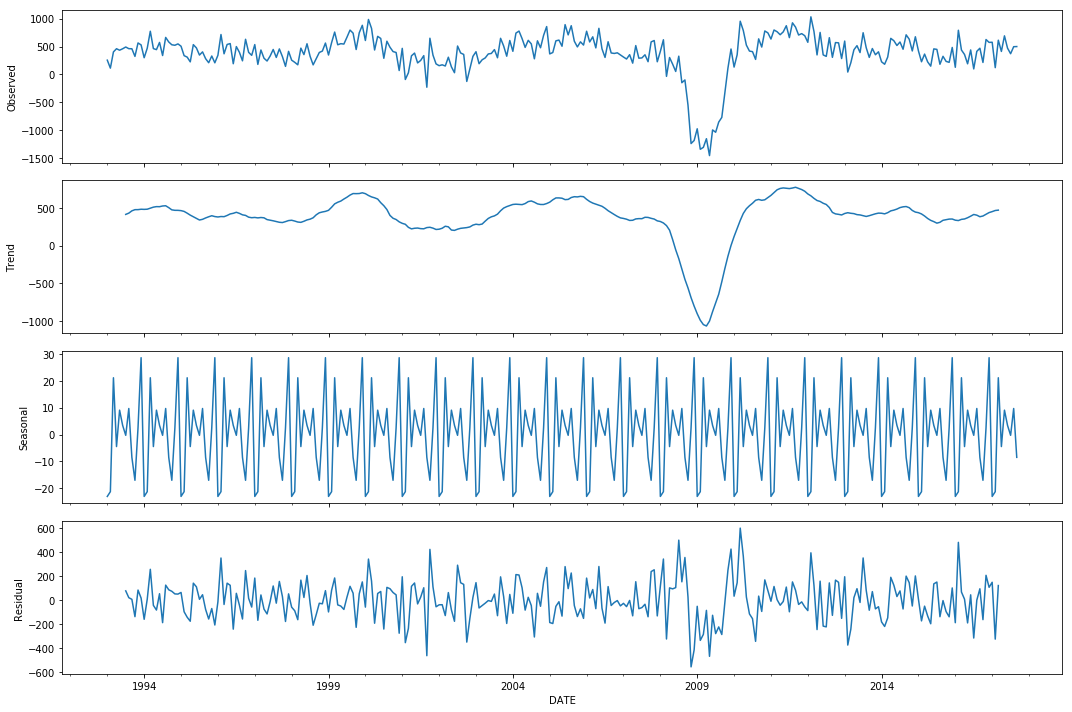

In [7]:
data['diff1'] = data.box - data.box.shift(12)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.diff1[12:])[1])
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.diff1[12:]).plot()
plt.show()

Критерий Дики-Фуллера < 0.05 и ряд стационарен, но тренд по прежнему не близок к нулю.  
Необходимо к сезонному добавить обычное дифференцирование.

Критерий Дики-Фуллера: p=0.000002


<Figure size 1080x720 with 0 Axes>

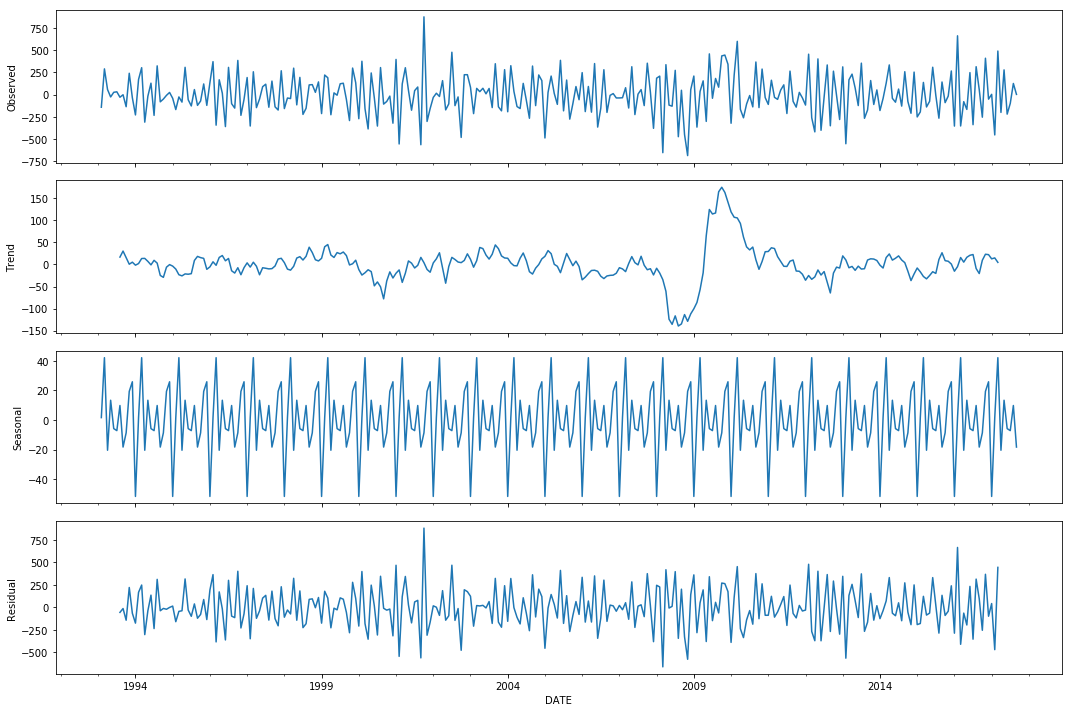

In [8]:
data['diff2'] = data.diff1 - data.diff1.shift(1)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.diff2[13:])[1])
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.diff2[13:]).plot()
plt.show()

Теперь практически всё в порядке, если не учитывать последствия кризиса 2008 на тренде.  
Но я оставлю как есть.  


Теперь необходимо составить графики автокорреляции и частичной автокорелляции, для подбора параметров Q,q,P,p

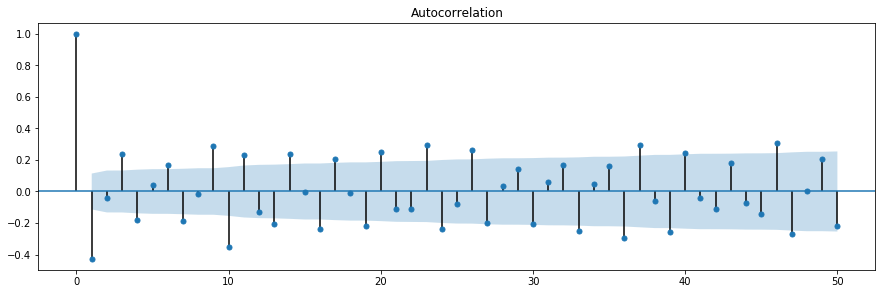

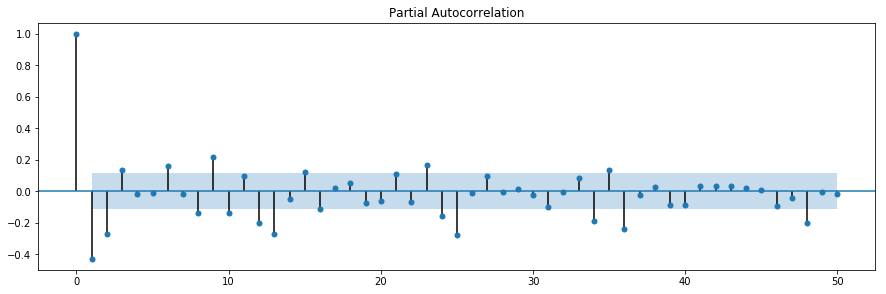

In [46]:
plt.figure(figsize(15,10))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

Параметры Q и q подбираются по графику автокорелляции, P,p по графику частичной автокорелляции.
Чтобы определить параметр Q нужно выбрать последний сезонный значимый лаг, в данном случае 36/12=3  
Параметр P так же сезонный 48/12=4
Параметры q и p несезонные и равны 1

Начальные приближения: Q=3, q=1, P=4, p=1

In [20]:
ps = range(0, 5)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 4)

In [21]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

80

Далее происходит перебор параметров и выбор лучшей модели по критерию Акайке

In [22]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 9min 8s


In [23]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
47  (2, 1, 1, 3)  3922.175351
74  (4, 1, 0, 2)  3927.983910
39  (2, 0, 1, 3)  3928.050099
75  (4, 1, 0, 3)  3929.457710
63  (3, 1, 1, 3)  3930.117548


Лучшая модель получилась с параметрами 2, 1, 1, 3  
Необходимо проанализировать остатки на наличие полезных данных

Критерий Стьюдента: p=0.901053
Критерий Дики-Фуллера: p=0.000660


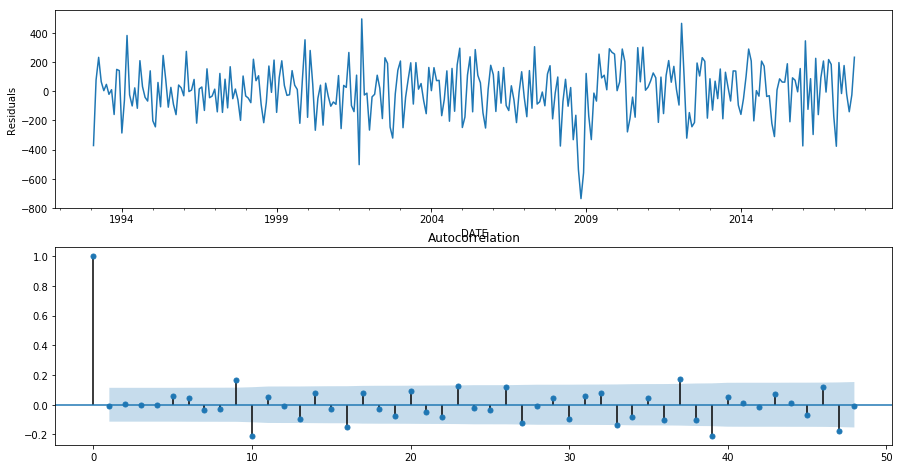

In [25]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Как видно, ничего полезного в остатках нет.  
Как же хорошо модель приближает данные, на которых она обучалась:

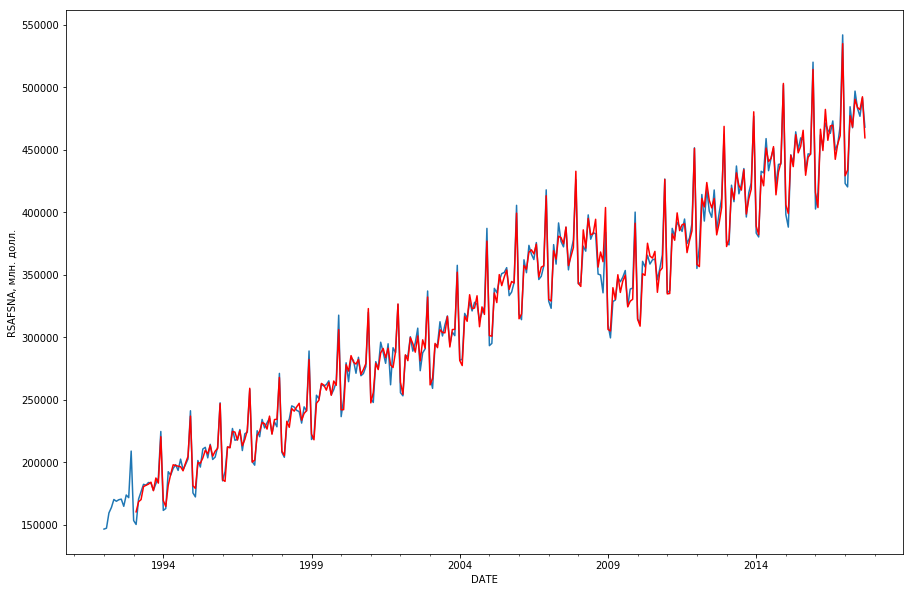

In [30]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,10))
data.RSAFSNA.plot()
data.model[13:].plot(color='r')
plt.ylabel('RSAFSNA, млн. долл.')
pylab.show()

Видно, что очень хорошо.  
Теперь можно постороить прогноз на 18 месяцев вперёд с 01.10.2017 по 01.03.2019

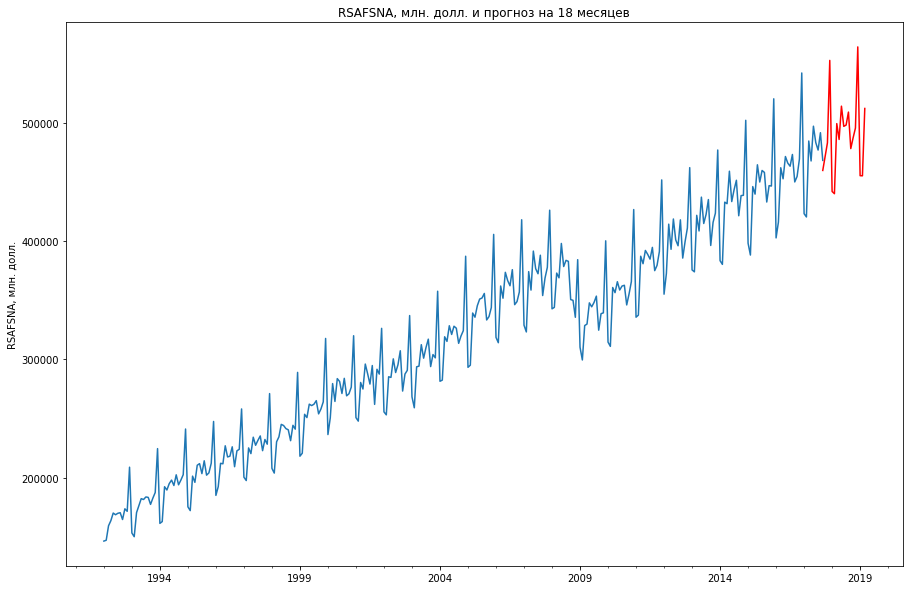

In [31]:
data2 = data[['RSAFSNA']]
date_list = [datetime.datetime.strptime("2017-10-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,18)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=308, end=330), lmbda)

plt.figure(figsize(15,10))
data2.RSAFSNA.plot()
data2.forecast.plot(color='r')
plt.ylabel(u'RSAFSNA, млн. долл.')
plt.title(u'RSAFSNA, млн. долл. и прогноз на 18 месяцев')
pylab.show()

По графику видно, что модель отлично прогнозирует сезонную зависимость и возрастающий тренд. 
  
Осталось понять, насколько хорошо она прогнозирует реальные данные.  
Я нашёл свежие данные RSAFSNA (https://fred.stlouisfed.org/series/RSAFSNA), теперь можно сравнить прогноз и реальные данные.

In [28]:
data_test=pd.read_csv('RSAFSNA2.csv',index_col=['DATE'], parse_dates=['DATE'], dayfirst=False)

In [29]:
data_test=data_test[data_test.index>'2017-08-01']

Выбираю данные только за прогнозный промежуток и строю два графика

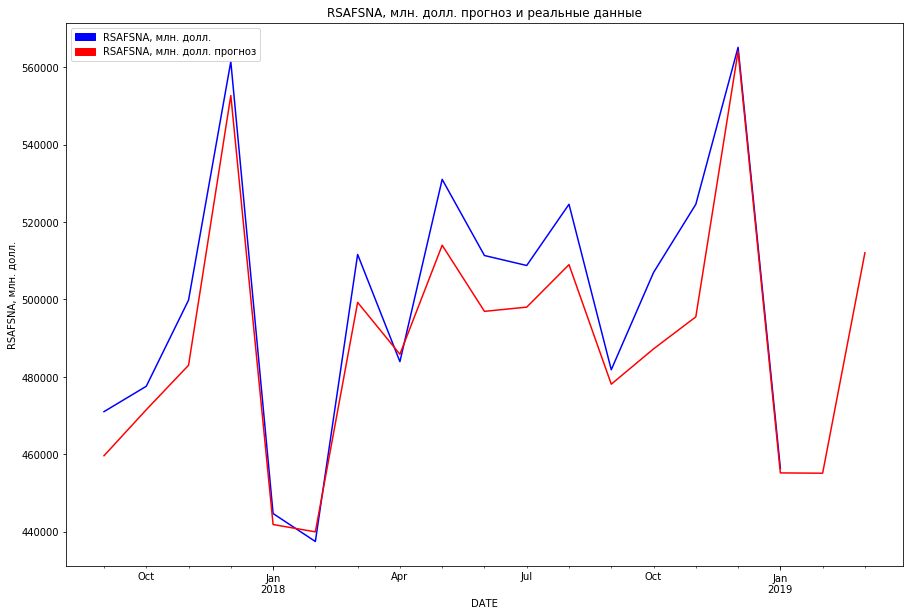

In [39]:
plt.figure(figsize(15,10))
data_test.RSAFSNA.plot(color='b')
data2.forecast.plot(color='r')
plt.ylabel(u'RSAFSNA, млн. долл.')
plt.title(u'RSAFSNA, млн. долл. прогноз и реальные данные')
blue_patch = mpatches.Patch(color='b', label='RSAFSNA, млн. долл.')
red_patch = mpatches.Patch(color='r', label='RSAFSNA, млн. долл. прогноз')
plt.legend(handles=[blue_patch,red_patch])
pylab.show()

По графику видно, что модель не плохо прогнозирует данные, но прогноз немного занижает.